### Minimization of Random Lindblad polynomial objective (with MomentTools)
Test minimization function on the Pade objective constructed from the Random Lindblad evolution sample

In [1]:
using LinearAlgebra
using Plots


(process:19632): GLib-GIO-WARNING **: 09:05:13.304: Unexpectedly, UWP app `Microsoft.MSPaint_6.2203.1037.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.MSPaint_8wekyb3d8bbwe!Microsoft.MSPaint') supports 17 extensions but has no verbs


#### Function to generate random Lindblad evolution w noise

Auxilary functions

In [2]:
using LinearAlgebra
using Plots

function rand_dm(n)
    # return a random density matrix
    ρ = -1 .+ 2 * rand(n, n) 
    ρ += im * (-1 .+ 2 * rand(n, n))  
    ρ = ρ * ρ'
    Hermitian(ρ / tr(ρ))
end

function rand_herm(n)
    # return a random hermitian matrix
    h = -1 .+ 2 * rand(n, n)
    h += im *(-1 .+ 2 *  rand(n, n))
    h = 0.5 * (h + h')
    Hermitian(h)
end

# Pauli matricies
σ = [
    [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1]
];


function bloch(ρ_list::Vector{Matrix{ComplexF64}})
    # Pauli matricies
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]
    time_steps = length(ρ_list)
    bloch_vec = zeros(3, time_steps)
    for t in 1:time_steps
        bloch_vec[:, t] = [real(tr(σ[i] * ρ_list[t])) for i=1:3]
    end
    bloch_vec
end

bloch (generic function with 1 method)

In [3]:
function rho_from_bloch(bloch_vec::Vector{Float64})
    # Pauli matricies
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]
    ρ = (sum([bloch_vec[i] * σ[i] for i=1:3]) + I)/2 
    ρ ::Matrix{ComplexF64}
end

function rho_series_from_bloch(bloch_vec::Matrix{Float64})
    time_steps = size(bloch_vec, 2)
    ρ = Vector{Matrix{ComplexF64}}() # size !!!
    for t in 1:time_steps
        push!(ρ, rho_from_bloch(bloch_vec[:, t]))     
    end
    ρ ::Vector{Matrix{ComplexF64}}
end

rho_series_from_bloch (generic function with 1 method)

In [4]:
function rho3d_from_bloch(bloch_vec::Matrix{Float64})
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]
    time_steps = size(bloch_vec, 2)
    ρ = zeros(2, 2, time_steps) + im*zeros(2, 2, time_steps)
    for t in 1:time_steps
        ρ[:, :, t] = (sum([bloch_vec[i, t] * σ[i] for i=1:3]) + I)/2       
    end
    ρ ::Array{ComplexF64, 3}
end

rho3d_from_bloch (generic function with 1 method)

Set Quantum basis and declare fynction to generate random Lindblad evolution

In [5]:
using Random
using QuantumOptics

basis = NLevelBasis(2) # define 2-level basis

tₘₐₓ = 2.0 # maximum time 
Δt = 0.05     # time step
time_span = [0:Δt:tₘₐₓ;] # time span

function rand_Linblad_w_noise(seed, w, t_list) # put t list here!!!!
    # seed - to generate reproducable system,
    # w - noise level
    # t_list - time span
    
    Random.seed!(seed)    
    
    ρ₀ = DenseOperator(basis, rand_dm(2))  # initial state density matrix
    H = DenseOperator(basis, rand_herm(2)) # Hamiltonian of the system
    J = DenseOperator(basis, (-1 .+ 2 *randn(2, 2)) + im*(-1 .+ 2 *randn(2, 2))) # Lindblad decipator  was rand !!!!!!
    
    time, ρ_exact = timeevolution.master(t_list, ρ₀, H, [J])

    ρ = [ (1 - w) * ρₜ.data + w * rand_dm(2) for ρₜ in ρ_exact ];
    
    bloch(ρ)    
end

rand_Linblad_w_noise (generic function with 1 method)

Lets generate and plot evolutuion of the Bloch vector using the function declared above 

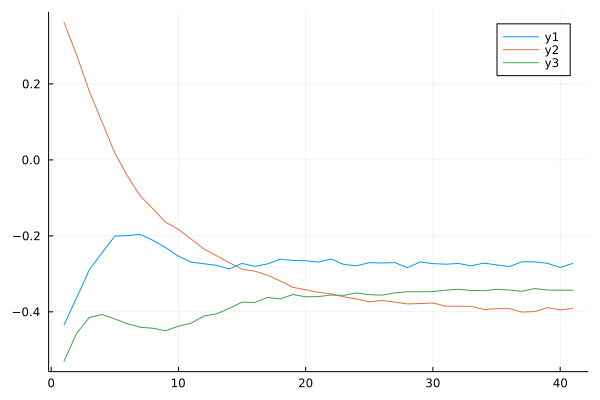

In [6]:
bv = rand_Linblad_w_noise(1000, 0.01, time_span) 
plot(bv')

In [7]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials, MomentTools
using MosekTools
using Random
using JuMP

Declare functions to constract Pade objective

In [8]:
function frobenius_norm2(m)
    return tr(m * m')
end

function lindblad_rhs(ρ, H, J)
    """
    Right hand side of the Lindblad master equation
    """
    return -1im * (H * ρ - ρ * H) + J * ρ * J' - (J' * J  * ρ + ρ * J' * J) / 2
    
end

function pade_obj(ρ::Array{ComplexF64,3}, t, H, J)
    
    obj = 0
    for i in 2:size(ρ,3)
        obj += frobenius_norm2(
            ρ[:, :, i] - ρ[:, :, i-1] 
            - (t[i]-t[i-1])*lindblad_rhs((ρ[:, :, i]+ρ[:, :, i-1])/2, H, J)
        )
    end
    obj = sum(real(coef) * mon for (coef, mon) in zip(coefficients(obj), monomials(obj)))
    return obj
end

function pade_obj(ρ::Vector{Matrix{ComplexF64}}, t, H, J)
    obj = 0
    for i in 2:size(ρ,1)
        obj += frobenius_norm2(
            ρ[i] - ρ[i-1] 
            - (t[i]-t[i-1])*lindblad_rhs((ρ[i]+ρ[i-1])/2, H, J)
        )
    end
    obj = sum(real(coef) * mon for (coef, mon) in zip(coefficients(obj), monomials(obj)))
    return obj
end

pade_obj (generic function with 2 methods)

Declare symbolic Hamiltonian and decipator

In [9]:
@polyvar x[1:4]
H_symb = [ 1.0 * x[1]              x[3] + im * x[4]
           x[3] - im * x[4]        x[2]             ]

@polyvar a[1:2, 1:2]
@polyvar b[1:2, 1:2]
J_symb = 1.0 * a + im * b

typeof(bv)

Matrix{Float64} (alias for Array{Float64, 2})

In [10]:
ρ_series = rho_series_from_bloch(bv);

In [11]:
@assert length(time_span)==length(ρ_series)

In [12]:
obj = pade_obj(ρ_series, time_span, H_symb, J_symb);

Declare function to perform local minimization of objective

In [13]:
using NLopt

function minimize_local(obj, guess) # polynomial objective, and guess x candidate
    vars = variables(obj)
    
    @assert length(vars) == length(guess)

    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)
    
    #set_silent(model)
    @variable(model, y[1:length(vars)]);
    
    for (var, init_val) in zip(y, guess)
        set_start_value(var, init_val)
    end
    
    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)
    solution = vars => map(value, y)
    
    return solution
end 

minimize_local (generic function with 1 method)

 Single function to perform all the process of minimization of objective

In [14]:
using DynamicPolynomials, MomentTools
using MosekTools
using JuMP

function minimize_global(obj)
    optimizer = optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)
    obj_min, M = minimize(obj, [], [], variables(obj), maxdegree(obj) ÷ 2, optimizer)
    
    r = get_minimizers(M)
    obj_min_vals = [obj(r[:,i]) for i=1:size(r)[2]]
    best_candidate = r[:, argmin(obj_min_vals)]
    
    minimize_local(obj, best_candidate) 
   
end 

minimize_global (generic function with 1 method)

In [15]:
solution = minimize_global(obj)

PolyVar{true}[x₁, x₂, x₃, x₄, a₁₋₁, a₂₋₁, a₁₋₂, a₂₋₂, b₁₋₁, b₂₋₁, b₁₋₂, b₂₋₂] => [-1.8149185758919868, 1.8147091043280439, 0.6218912146770148, -4.495291394582347, -1.1375700947887937, -0.22566911574404938, 0.3311522980761146, 0.6738237872756939, 0.13841101176151122, 1.8451341715780316, -0.2142014404206339, -0.9103258129340991]

In [16]:
obj(solution)

0.0020954284485980093

Restore identified Hamiltonian and disipator <br>

To save we can use: <br>
H_sid = convert(Matrix{ComplexF64}, subs(H_symb, solution))<br>
J_sid = convert(Matrix{ComplexF64}, subs(J_symb, solution))

In [17]:
H_sid = subs(H_symb, solution)
J_sid = subs(J_symb, solution)

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (-1.13757+0.138411im)  (0.331152-0.214201im)
 (-0.225669+1.84513im)  (0.673824-0.910326im)

Now lets simulate Lindbland dynamics with new identified parameters

In [18]:
using QuantumOptics

ρ0_sid = DenseOperator(basis, Hermitian(ρ_series[1])) 

H_sid = DenseOperator(basis, H_sid) # Hamiltonian of the system
J_sid = DenseOperator(basis, J_sid)

Operator(dim=2x2)
  basis: NLevel(N=2)
 (-1.13757+0.138411im)  (0.331152-0.214201im)
 (-0.225669+1.84513im)  (0.673824-0.910326im)

In [19]:
time, ρ_sid_ser  = timeevolution.master(time_span, ρ0_sid, H_sid, [J_sid]);

In [20]:
ρ_sid = [ρₜ.data for ρₜ in ρ_sid_ser];

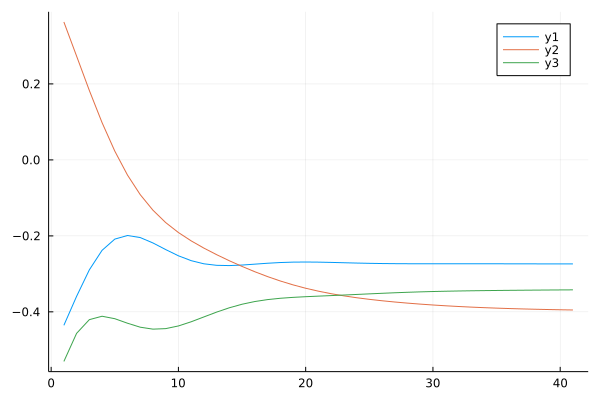

In [21]:
bv_sid = bloch(ρ_sid) 
plot(bv_sid')

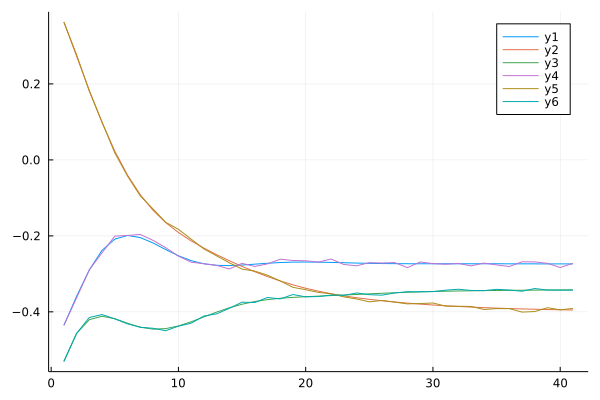

In [22]:
plot(bv_sid')
plot!(bv')

In [23]:
seeds = rand(UInt, 100000)
@assert allunique(seeds)